In [1]:
from summary_eval.data import summary_df, prompts_df
from summary_eval.settings import TRAIN_SIZE
from summary_eval.testing import cross_validate

2024-02-29 20:47:19,083 - INFO - Read 7165 summaries from C:\Users\theaw\summary-eval\data\summaries_train.csv
2024-02-29 20:47:19,100 - INFO - Read 4 prompts from C:\Users\theaw\summary-eval\data\prompts_train.csv


In [45]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [31]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.chunk import ne_chunk

nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\theaw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [3]:
train_df, test_df = train_test_split(summary_df, train_size=TRAIN_SIZE, random_state=42)

<Axes: >

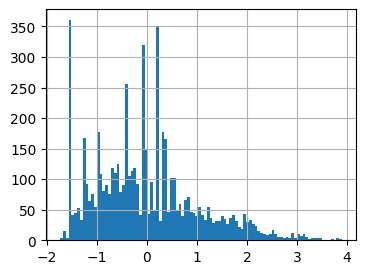

In [9]:
train_df["content"].hist(figsize=(4,3), bins=100)

<Axes: >

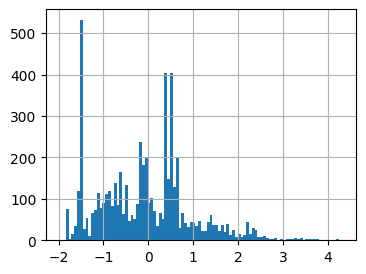

In [11]:
train_df["wording"].hist(figsize=(4,3), bins=100)

Text(0, 0.5, 'Wording')

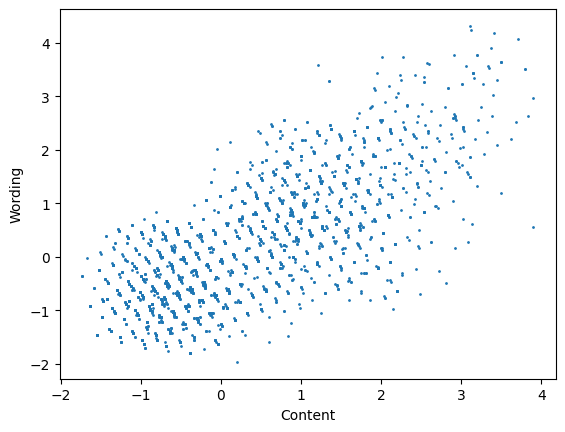

In [21]:
plt.scatter(train_df["content"], train_df["wording"], s=1)
plt.xlabel("Content")
plt.ylabel("Wording")

In [38]:
join_df = train_df.merge(prompts_df, on="prompt_id")

In [29]:
p1 = prompts_df["prompt_text"].iloc[0]
p1

'Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, 

## Proper Noun-based Features

In [37]:
def is_any_alpha(input_string):
    return any(char.isalpha() for char in input_string)

def extract_proper_nouns(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    proper_nouns = set()
    for tagged_word in tagged_words:
        if isinstance(tagged_word, tuple) and tagged_word[1] == 'NNP':
            if is_any_alpha(tagged_word[0]) is True:
                proper_nouns.add(tagged_word[0])
    return list(proper_nouns)

extract_proper_nouns(p1)

['Telephus',
 'Alcmaeon',
 'Aegisthus',
 'Thyestes',
 'Comedy',
 'Odyssey',
 'Tragedy',
 'Euripides',
 'Orestes',
 'Meleager',
 'Oedipus']

### Intersection of Proper Nouns in Prompt and Summary

In [65]:
def prop_noun_intersection(prompt_prop_nouns, summary):
    prompt_proper_nouns = set(prompt_prop_nouns)
    summary_proper_nouns = set(extract_proper_nouns(summary))
    return len(prompt_proper_nouns.intersection(summary_proper_nouns))/len(prompt_proper_nouns)

prompt_prop_nouns = {}
for i, prompt in prompts_df.iterrows():
    prompt_prop_nouns[prompt["prompt_id"]] = extract_proper_nouns(prompt["prompt_text"])

train_df["proper_noun_intersection"] = train_df.progress_apply(lambda row: prop_noun_intersection(prompt_prop_nouns[row["prompt_id"]], row["text"]), axis=1)
train_df["proper_noun_intersection"] 

100%|██████████| 5732/5732 [00:26<00:00, 214.26it/s]


2441    0.117647
3901    0.000000
4267    0.000000
6189    0.000000
4119    0.000000
          ...   
3772    0.000000
5191    0.000000
5226    0.090909
5390    0.000000
860     0.000000
Name: proper_noun_intersection, Length: 5732, dtype: float64

Text(0, 0.5, 'Proper Noun Intersection')

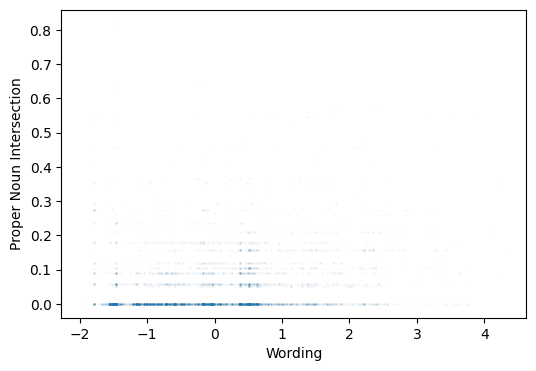

In [64]:
plt.figure(figsize=(6, 4))
plt.scatter(train_df["wording"], train_df["proper_noun_intersection"], s=1, alpha=0.02)
plt.xlabel("Wording")
plt.ylabel("Proper Noun Intersection")

Text(0, 0.5, 'Proper Noun Intersection')

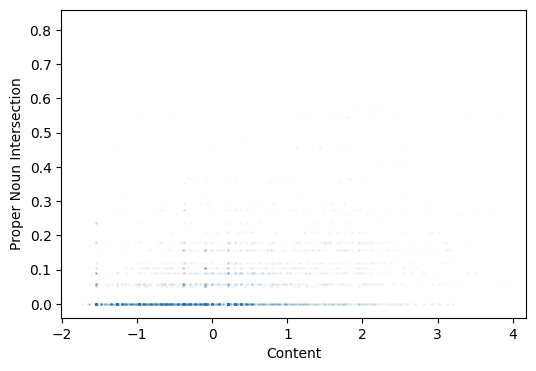

In [63]:
plt.figure(figsize=(6, 4))
plt.scatter(train_df["content"], train_df["proper_noun_intersection"], s=1, alpha=0.02)
plt.xlabel("Content")
plt.ylabel("Proper Noun Intersection")

## Proper Noun Count

In [66]:
def num_proper_nouns_in_summary(prompt_prop_nouns, summary):
    prompt_proper_nouns = set(prompt_prop_nouns)
    summary_words = summary.split()
    count=0
    for word in prompt_proper_nouns:
        count += summary_words.count(word)
    return count

prompt_prop_nouns = {}
for i, prompt in prompts_df.iterrows():
    prompt_prop_nouns[prompt["prompt_id"]] = extract_proper_nouns(prompt["prompt_text"])

train_df["proper_noun_count"] = train_df.progress_apply(lambda row: num_proper_nouns_in_summary(prompt_prop_nouns[row["prompt_id"]], row["text"]), axis=1)
train_df["proper_noun_count"] 

100%|██████████| 5732/5732 [00:00<00:00, 20621.49it/s]


2441    2
3901    0
4267    0
6189    0
4119    0
       ..
3772    0
5191    1
5226    0
5390    0
860     0
Name: proper_noun_count, Length: 5732, dtype: int64

Text(0, 0.5, 'Proper Noun Count')

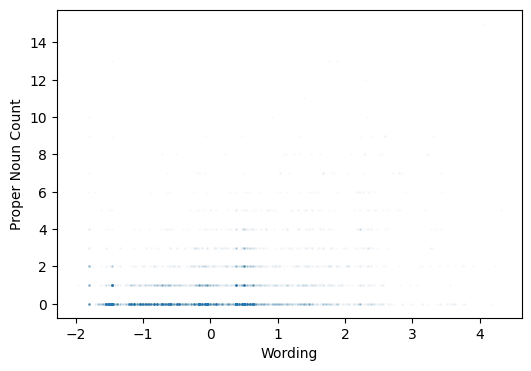

In [67]:
plt.figure(figsize=(6, 4))
plt.scatter(train_df["wording"], train_df["proper_noun_count"], s=1, alpha=0.02)
plt.xlabel("Wording")
plt.ylabel("Proper Noun Count")

Text(0, 0.5, 'Proper Noun Count')

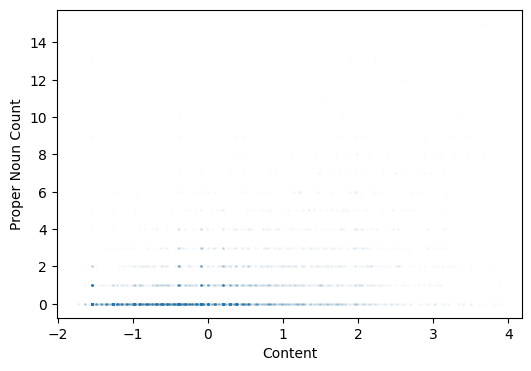

In [68]:
plt.figure(figsize=(6, 4))
plt.scatter(train_df["content"], train_df["proper_noun_count"], s=1, alpha=0.02)
plt.xlabel("Content")
plt.ylabel("Proper Noun Count")

## Evaluate Model